# Import package and module

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import zip_longest
import matplotlib.image as mpimg

In [15]:
tf.config.list_physical_devices("GPU")
!nvidia-smi

Mon May 23 14:08:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:29:00.0  On |                  N/A |
|  0%   49C    P8    20W / 125W |   5524MiB /  6144MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load path

In [3]:
try:
    set_pick = int(input("Dataset : 1. Kaggle  2. Mendley  3. Custom Mendley  4.Custom Mendley 80"))
    if set_pick == 1:
        # Kaggle dataset dir
        train_dir = './cigarette-smoker-detection-kaggle/train'
        test_dir = './cigarette-smoker-detection-kaggle/test'

        print("Kaggle dataset selected")

    elif set_pick == 2:
        # Mendley dataset dir 
        train_dir = './dataset_mendley/training_data'
        val_dir = './dataset_mendley/validation_data'
        test_dir = './dataset_mendley/testing_data'
        
        print("Mendley dataset selected")
        
    elif set_pick == 3:
        # Mendley 75 dataset dir 
        train_dir = './dataset_mendley_custom/training_data'
        val_dir = './dataset_mendley_custom/validation_data'
        test_dir = './dataset_mendley_custom/testing_data'
        
        print("Custom dataset selected")

    elif set_pick == 4:
        # Mendley 80 dataset dir 
        train_dir = './dataset_mendley_80/training_data'
        val_dir = './dataset_mendley_80/validation_data'
        test_dir = './dataset_mendley_80/testing_data'
        
        print("Custom dataset 80 selected")

    else:
        raise Exception("Input 1/2/3/4")
except ValueError:
    print("Wrong input value!!!")

Custom dataset 80 selected


# Preprocessing

### Preprocessing

In [4]:
img_size = 224
batch_size = 32
seed = 72

if set_pick == 1:

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="training",
        seed=seed,
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        label_mode="binary",
        image_size=(img_size,img_size),
        batch_size=batch_size
    )

else:

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=seed,
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        seed=seed,
        label_mode="binary",
        image_size=(img_size,img_size),
        batch_size=batch_size
    )

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 1930 files belonging to 2 classes.
Found 240 files belonging to 2 classes.
Found 240 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names
class_names

['notsmoking', 'smoking']

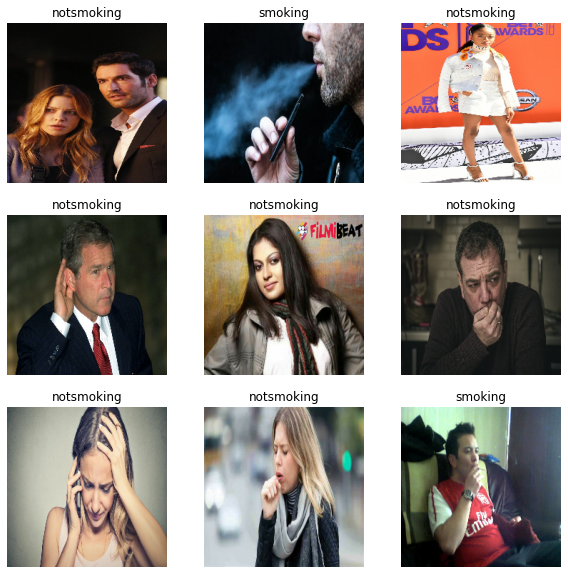

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i].numpy()[0])])
    plt.axis("off")

## Rescale

In [68]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
print("\nRescale Successful")


Rescale Successful


# Train

In [5]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(img_size, img_size, 3),
    weights="imagenet",
    include_preprocessing=False,
    include_top=False,
    pooling="avg"
)

base_model.trainable = False
# for layer in base_model.layers[:-7]:
#     layer.trainable = False

In [6]:
model = tf.keras.Sequential([
                            base_model,
                            tf.keras.layers.Dropout(0.5, seed = seed),
                            tf.keras.layers.Dense(units=1, activation = "sigmoid")
])

In [7]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()
                       #,tfa.metrics.F1Score(num_classes= 2 )
                       ])

Model Summary

In [8]:
# model.summary(expand_nested=True)
model.summary()
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True
# )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


In [15]:
fb_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()

tf.lite.experimental.Analyzer.analyze(model_content=fb_model)

INFO:tensorflow:Assets written to: C:\Users\Aisen\AppData\Local\Temp\tmpva5uu1zw\assets


INFO:tensorflow:Assets written to: C:\Users\Aisen\AppData\Local\Temp\tmpva5uu1zw\assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #43 and tensor #90 as input and produces tensor #131 as output.

Subgraph#0 main(T#0) -> [T#253]
  Op#0 CONV_2D(T#0, T#43, T#90) -> [T#131]
  Op#1 HARD_SWISH(T#131) -> [T#132]
  Op#2 DEPTHWISE_CONV_2D(T#132, T#91, T#22) -> [T#133]
  Op#3 CONV_2D(T#133, T#44, T#92) -> [T#134]
  Op#4 ADD(T#132, T#134) -> [T#135]
  Op#5 CONV_2D(T#135, T#45, T#23) -> [T#136]
  Op#6 PAD(T#136, T#19) -> [T#137]
  Op#7 DEPTHWISE_CONV_2D(T#137, T#93, T#24) -> [T#138]
  Op#8 CONV_2D(T#138, T#46, T#94) -> [T#139]
  Op#9 CONV_2D(T#139, T#47, T#25) -> [T#140]
  Op#10 DEPTHWISE_CONV_2D(T#140, T#95, T#26) -> [T#141]
  Op#11 CONV_2D(T#141, T#48, T#96) -> [T#142]
  Op#12 ADD(T#139, T#142) -> [T#143]
  Op#13 CONV_2D(T#143, T#49, T#27) -> [T#144]
  Op#14 PAD(T#144, T#21) -> [T#145]
  Op#15 DEPTHWISE_CONV_2D(T#145, T

Start train

In [9]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds)
)

print("\n==========================")
print("======= Train done =======")
print("==========================")

Epoch 1/300
61/61 [==============================] - 34s 366ms/step - loss: 0.6928 - accuracy: 0.6617 - precision: 0.6538 - recall: 0.6870 - val_loss: 0.4126 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 2/300
61/61 [==============================] - 11s 158ms/step - loss: 0.4654 - accuracy: 0.7948 - precision: 0.7960 - recall: 0.7927 - val_loss: 0.3392 - val_accuracy: 0.8625 - val_precision: 0.8850 - val_recall: 0.8333
Epoch 3/300
61/61 [==============================] - 11s 152ms/step - loss: 0.4089 - accuracy: 0.8233 - precision: 0.8237 - recall: 0.8228 - val_loss: 0.3249 - val_accuracy: 0.8625 - val_precision: 0.9143 - val_recall: 0.8000
Epoch 4/300
61/61 [==============================] - 11s 153ms/step - loss: 0.3571 - accuracy: 0.8518 - precision: 0.8504 - recall: 0.8539 - val_loss: 0.3077 - val_accuracy: 0.8583 - val_precision: 0.9135 - val_recall: 0.7917
Epoch 5/300
61/61 [==============================] - 11s 155ms/step - loss: 0.3315 - accuracy: 0

Result #1 train

In [10]:
acc = history_1.history['accuracy']
prec = history_1.history['precision']
recall = history_1.history['recall']
loss = history_1.history['loss']

val_acc = history_1.history['val_accuracy']
val_prec = history_1.history['val_precision']
val_recall = history_1.history['val_recall']
val_loss = history_1.history['val_loss']

In [15]:
save_path = './Developed-model/exp15'
model.save(save_path)
print("\nModel has been saved")

INFO:tensorflow:Assets written to: ./Developed-model/exp15\assets


INFO:tensorflow:Assets written to: ./Developed-model/exp15\assets



Model has been saved


In [14]:
print("\nEvaluating the model with test set")
model.evaluate(test_ds)


Evaluating the model with test set
8/8 [==============================] - 3s 41ms/step - loss: 0.2287 - accuracy: 0.9208 - precision: 0.9316 - recall: 0.9083


[0.22874635457992554,
 0.9208333492279053,
 0.9316239356994629,
 0.9083333611488342]

# Export metrics result to csv

In [11]:
data = [acc, prec, recall, loss, val_acc, val_prec, val_recall, val_loss]
export_data = zip_longest(*data, fillvalue = '')

with open('exp15.csv', 'w', encoding="ISO-8859-1", newline='') as file:
      write = csv.writer(file)
      write.writerow(("acc", "prec", "recall", "loss", "val_acc", "val_prec", "val_recall", "val_loss"))
      write.writerows(export_data)

print("\nTrain result has been saved")


Train result has been saved


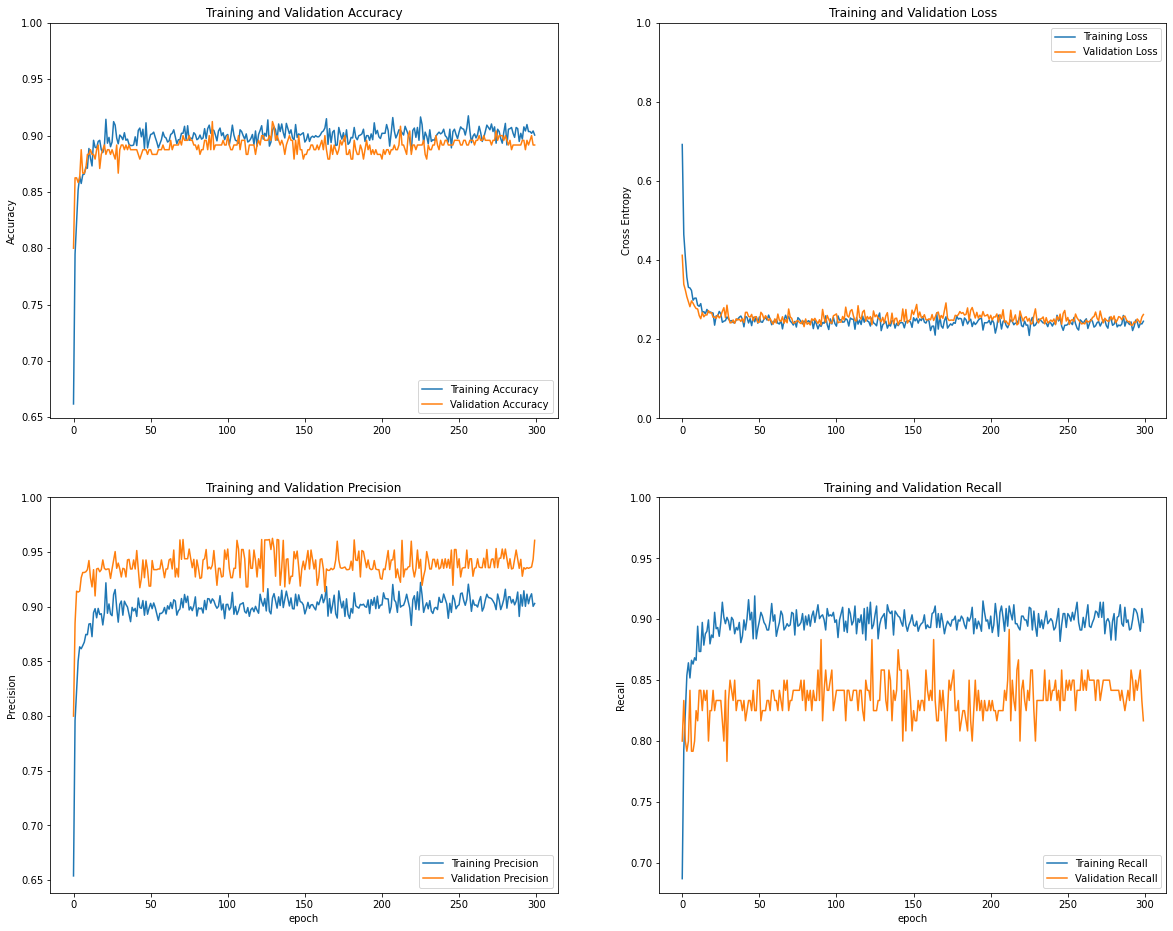

In [13]:
plt.figure(figsize=(20, 16))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(prec, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')

plt.xlabel('epoch')
plt.show()

# Prediction result

Load model

In [7]:
model = tf.keras.models.load_model('Developed-model/exp15')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


In [8]:
def load_and_prep_image(filename, img_shape=224):
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.

  img = tf.expand_dims(img, axis= 0)
  return img

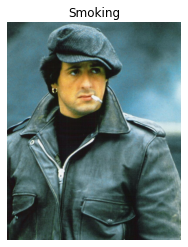

In [38]:
imagedir = "./dataset_mendley_80/testing_data/smoking/abc099.jpg"
testimage = mpimg.imread(imagedir)
plt.imshow(testimage)
plt.title("Smoking")
plt.axis(False);

testimage = load_and_prep_image(imagedir)

In [39]:
pred = model.predict(testimage)
train_ds.class_names[int(tf.round(pred)[0][0])]

'notsmoking'

Batch prediction

In [9]:
smoke_list = os.listdir("./dataset_mendley_80/testing_data/smoking")
notsmoke_list = os.listdir("./dataset_mendley_80/testing_data/notsmoking")

In [94]:
miss_predictions = []

for i in range(len(smoke_list)):
    imagedir = f"./dataset_mendley_80/testing_data/smoking/{smoke_list[i]}"

    image = load_and_prep_image(imagedir)
    image = model.predict(image)
    result = class_names[int(tf.round(image)[0][0])]
    if result == "notsmoking":
        print(f"{imagedir} wrong prediction")
        read = mpimg.imread(imagedir)
        miss_predictions.append({"dir" :imagedir, "result":image[0][0]})
    else:
        print(f"{imagedir} correctly predicted")
        

./dataset_mendley_80/testing_data/smoking/abc081.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc082.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc083.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc084.jpg wrong prediction
./dataset_mendley_80/testing_data/smoking/abc085.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc086.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc087.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc088.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc089.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc090.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc091.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc092.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc093.jpg correctly predicted
./dataset_mendley_80/testing_data/smoking/abc094.jpg c

True negative

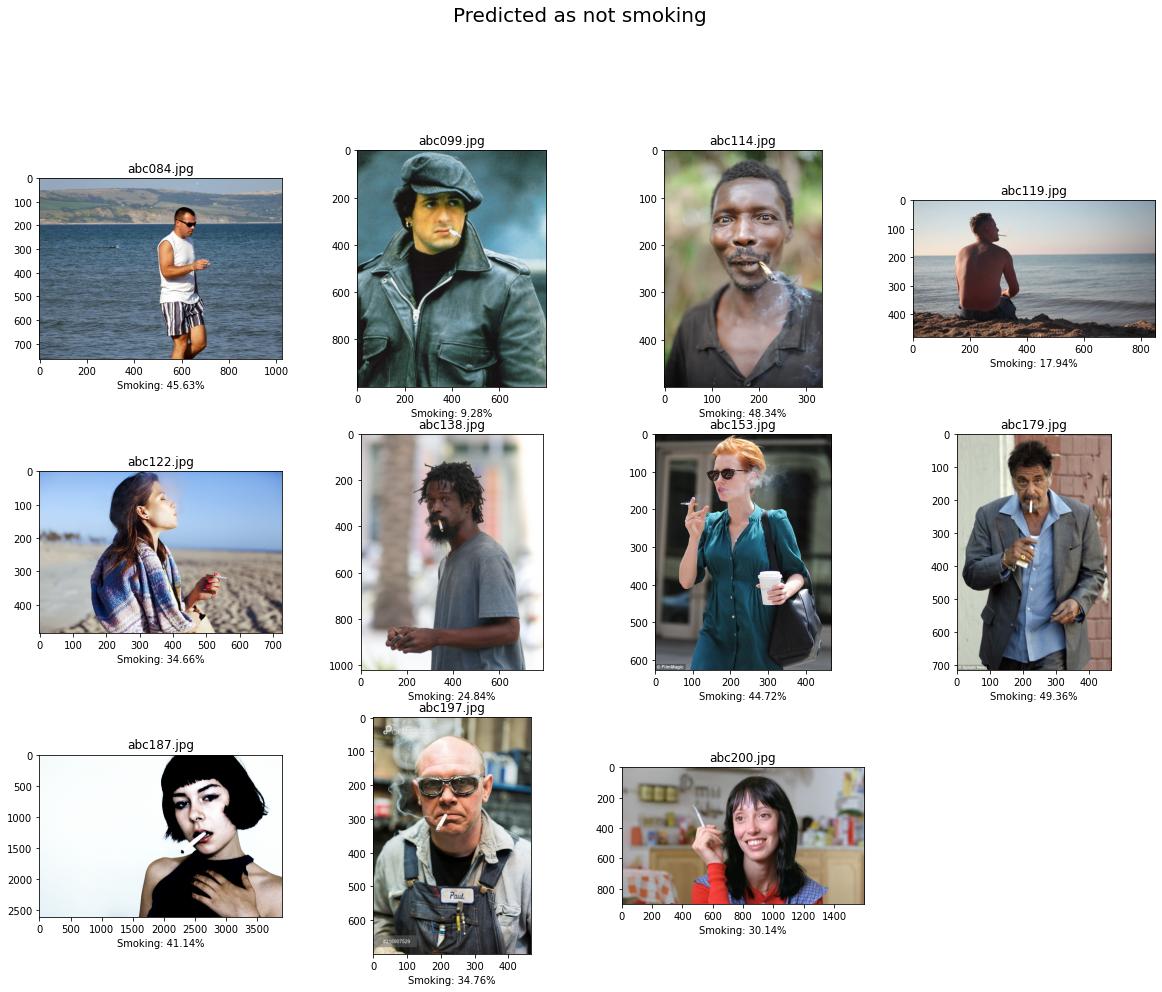

In [100]:
plt.figure(figsize=(20, 20))
plt.suptitle("Predicted as not smoking", fontsize=20)
for i in range(len(miss_predictions)):
  read = mpimg.imread(miss_predictions[i]["dir"])
  miss_result = miss_predictions[i]["result"]

  ax = plt.subplot(4, 4, i + 1)
  plt.title(miss_predictions[i]["dir"][-10::])
  plt.xlabel(f"Smoking: {miss_result:.2%}")
  plt.imshow(read)
  # ax.set_xticks([])
  # ax.set_yticks([])

In [104]:
miss_predictions = []

for i in range(len(notsmoke_list)):
    imagedir = f"./dataset_mendley_80/testing_data/notsmoking/{notsmoke_list[i]}"

    image = load_and_prep_image(imagedir)
    image = model.predict(image)
    result = class_names[int(tf.round(image)[0][0])]
    if result == "smoking":
        print(f"{imagedir} wrong prediction")
        read = mpimg.imread(imagedir)
        miss_predictions.append({"dir" :imagedir, "result":image[0][0]})
    else:
        print(f"{imagedir} correctly predicted")
        

./dataset_mendley_80/testing_data/notsmoking/abc400.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc281.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc282.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc283.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc284.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc285.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc286.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc287.jpg wrong prediction
./dataset_mendley_80/testing_data/notsmoking/abc288.JPG correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc289.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc290.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc291.jpg correctly predicted
./dataset_mendley_80/testing_data/notsmoking/abc292.jpg correctly predicted
./dataset_mendl

False positive

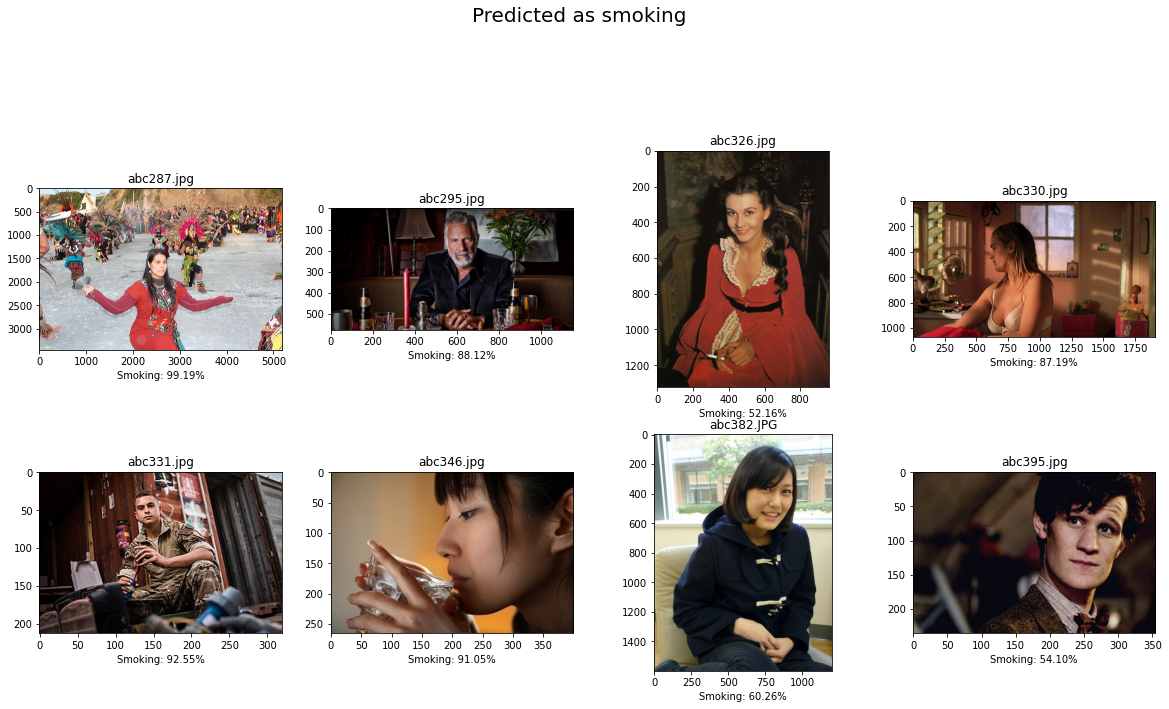

In [102]:
plt.figure(figsize=(20, 20))
plt.suptitle("Predicted as smoking", fontsize=20)
for i in range(len(miss_predictions)):
  read = mpimg.imread(miss_predictions[i]["dir"])
  miss_result = miss_predictions[i]["result"]

  ax = plt.subplot(4, 4, i + 1)
  plt.title(miss_predictions[i]["dir"][-10::])
  plt.xlabel(f"Smoking: {miss_result:.2%}")
  plt.imshow(read)
  # ax.set_xticks([])
  # ax.set_yticks([])